
 ... IMPORT STARTING ...


	VERSION INFORMATION
		- NUMPY VERSION: 1.26.4
		- SKLEARN VERSION: 1.2.2
		- CV@ VERSION 4.10.0
		- MATPLOTLIB VERSION: 3.7.5
IS DEBUG: True




... IMPORTS COMPLETED ...



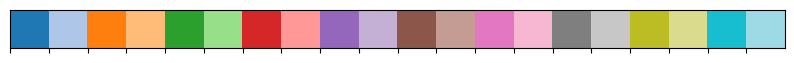

In [20]:
print("\n ... IMPORT STARTING ...\n")
print("\n\tVERSION INFORMATION")


import pandas as pd; #pd.options.mode.chained_assignnment = None; pd.set_option(' display.max_column', None); import pandas;
import numpy as np; print(f"\t\t- NUMPY VERSION: {np.__version__}");
import sklearn; print(f"\t\t- SKLEARN VERSION: {sklearn.__version__}")
from sklearn.metrics import roc_curve, auc, roc_auc_score
import cv2; print(f"\t\t- CV@ VERSION {cv2.__version__}");

# for modeling and dataset
import lightgbm as lgb
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import OrdinalEncoder

# Built-in imports
from typing import Iterable, Any, Callable, Generator
from kaggle_datasets import KaggleDatasets
from dataclasses import dataclass
from collections import Counter
from datetime import datetime
from zipfile import ZipFile
from glob import glob
import subprocess
import warnings
import requests
import textwrap
import hashlib
import imageio
import IPython
import urllib
import zipfile
import pickle
import random
import shutil
import h5py
import json
import copy
import math
import time
import gzip
import ast
import sys
import io
import gc
import re
import os

#visualization Imports 
from IPython.core.display import HTML, Markdown
import matplotlib.pyplot as plt
from matplotlib import animation, rc; rc('animation', html='jshtml')
from tqdm.notebook import tqdm;tqdm.pandas()
import plotly.graph_objects as go
import plotly.express as px
import plotly
import seaborn as sns
from PIL import Image, ImageEnhance, ImageColor; Image.MAX_IMAGE_PIXELS = 5_000_000_000;
import matplotlib; print(f"\t\t- MATPLOTLIB VERSION: {matplotlib.__version__}")
from colorama import Fore, Style, init; init()
import PIL

def hex_to_rgb(hex_color: str) -> tuple:
        """Convert hex color to RGB tuple,
        
        Args:
            hex_color (str): The hex color string, string with '#'.
            
        Returns:
            tuple: A tuple of RGB values.
        """
        hex_color = hex_color.lstrip('#')
        return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def clr_print(text: str, color: str = "#42BFBA", bold: bool = True) -> None:
    """Print the given text with the specified color and bold formatting.
    
    Args :
        text (str): The text to format.
        color (str): The hex color code to apply. Defaults to "#42BFBA"
        bold (bool): Wether to apply bold formtiing. Defaults to True.
    """
    _text = text.replace('\n', '<br>')
    rgb = hex_to_rgb(color)
    color_style = f"color: rgb({rgb[0]}, {rgb[1]}, {rgb[2]});"
    bold_style = "font-weight: bold;" if bold else"" 
    style = f"{color_style} {bold_style}"
    display(HTML(f"<span style='{style}'>{_text}</span>"))

def seed_it_all(seed=7):
    """ Attempt to be Reproducible """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    #tf.random.set_seed(seed)
seed_it_all()

# Create Seaborn color palette
nb_palette = sns.color_palette(palette='tab20')

# create colors for class table
LABELS = ['Benign', 'Malignant']
COLORS = ['#66c2a5', '#fc8d62']
CLR_MAP_I2C = {i:c for i,c in enumerate(COLORS)}
CLR_MAP_S2C = {i:c for i,c in zip(LABELS,COLORS)}
LBL_MAP_I2S = {i:l for i,l in enumerate(LABELS)}
LBL_MAP_S2I = {v:k for v,k in LBL_MAP_I2S.items()}

# Is this notebook being run on the backend for scoring re-submission
IS_DEBUG = False if os.getenv("KAGLLE_IS_COMPETITION_RERUN") else True
print(f"IS DEBUG: {IS_DEBUG}")

#plot the palette
clr_print("\... NOTEBOOK COLOR PALETTE ...")
sns.palplot(nb_palette, size=0.5)
plt.show(

print("\n\n... IMPORTS COMPLETED ...\n"))


In [24]:
"""2024 ISIC Challenger promary prize scoring metric

Given a list of binary labels, an associated list of prediction
score ranging from [0.1], this function produces, as a single value, 
the partial area under the recceiver operating characteristic (pAUC)
above a given true positive rate (TPR).
https://en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.

(c) 2024 nicholas R Kurtansky, MSKCC
"""


class ParticipantVissibleError(Exception):
    pass

def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str, main_tps: float= 0.80) -> float:
    '''
    2024 ISIC Challenge metric : pAUC
    
    Given a solution file and submission file, this fuction returns
    the partial area under the receiver operating characteristic (pAUC)
    above a given true positive rate (TPR) = 0.80.
    https;//en.wikipedia.org/wiki/Partial_Area_Under_the_ROC_Curve.
    
    (c) 2024 Nicholas R Kurtansky, MSKCC
    
    Args:
        solution: Ground truth pd.DataFrame of 1s and 0s
        submissionl solution dataframe of predictions of scores ranging [0, 1]
        
    Returns:
        Float value range [0, max_fpr]
        '''
    
    del solution[row_id_column_name]
    del submission[row_id_column_name]
    
    # Check submission is numeric
    if not pandas.api.types.is_numeric_stype(submission.values):
        raise ParticipantVissibleError('Submission target column must be numeric')
    # rescale the target. set 0s to 1s and 1s to 0s (since sklearn only has max_fpr)
    v_gt = abs(np.asarray(solution.values)-1)
    
    #flip the submission to their compliments
    v_pred = -1.0*np.asarray(submission.values)
    
    max_fpr = abs(1-min_tpr)
    
    # using sklearn.metric function: (1) roc_curve and (2) auc
    fpr, tpr, _ = roc_curve(v_gt, v_pred, sample_weight=None)
    if max_fpr is None or max_fpr== 1:
        return auc(fpr, tpr)
    if max_fpr <= 0 or max_fpr>1:
            raise ValueError("Expected min_tpr in range [0, 1], got: %r"%min_tpr)
    # Add a single point at max_fpr by linear interpolation
    stop = np.searchsorted(fpr, max_fpr, "right")
    x_interp = [fpr[stop - 1], fpr[stop]]
    y_interp = [tpr[stop - 1], tpr[stop]]
    tpr = np.append(tpr[:stop], np.interp(max_fpr, x_interp, y_interp))
    fpr = np.append(fpr[:stop], max_fpr)
    partial_auc = auc(fpr, tpr)
    
    return partial_auc